# Описание конкурса

Машинное обучение: часть 1

Сроки проведения: 07.08.22 - 22.08.22

До конца осталось:13 дней:22 часа

Баллы за каждую задачу вычисляются на основе загруженных предсказаний для соответствующего тестового набора данных. В обеих задачах тестовый набор предварительно разделен на две части: публичную (public, 45%) и приватную (private, 55%). Каждый раз после загрузки решения участнику отображаются баллы, посчитанные на публичной части. Они не видны другим участникам соревнования. Далее после завершения соревнования в качестве итоговых баллов за задачу берутся баллы, посчитанные на соответствующей приватной части в лучшем загруженном участником решении.

Обращаем внимание, что участник должен отправить предсказания для всего тестового набора.

# Рабочее окружение

Для библиотеки Sber LAMA требуется специфические версии PyTorch и других библиотек. Лучше создть conda отдельное рабочее окружение:

    conda create -n sber_lama python=3.9.7

с той же версией python, что и в окружении base. И уже потом находясь в этом окружении выполнить команду по устновке lighautoml:

    !pip install -U lightautoml

Менеджер пакетов сам установит все нужные зависисмоти нужных версий.

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 151
model name	: 12th Gen Intel(R) Core(TM) i5-12600
stepping	: 5
microcode	: 0x1f
cpu MHz		: 3300.000
cache size	: 18432 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 32
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdseed adx smap clflushopt clwb intel_pt sha_

In [2]:
!nvidia-smi

Wed Aug 10 16:59:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   45C    P0    56W / 150W |      0MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Завершить все процессы, использующие ГПУ в нашей ОС
# !fuser -k /dev/nvidia[0]

In [ ]:
# установим AutoML фреймворк от Сбера - LightAutoML(LAMA)
# это позволит довольно быстро проверять различные гипотезы и 
# отбирать лучшие решения
# (устанавливаем только 1 раз)
# !pip install -U lightautoml

In [18]:
# Импортируем модули
import os
import time
import re
import joblib

# уже установленные библиотеки
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# импорты из LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [5]:
# Загрузим обучающие данные и посмотрим на них.
train_data = pd.read_csv('data/train.csv')
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,target
0,-6.130724,7.429628,3.651437,-1.950971,-3.384415,1.095934,-3.077774,-2.619091,5.128201,1.228476,...,0.392978,4.920467,16.610460,-2.430804,-1.405573,18.610209,-4.140715,6.027816,-20.288145,0
1,5.161836,-6.514011,-7.474612,-4.544336,-13.081404,1.637562,-1.094672,-1.253545,-2.955342,-10.958200,...,-4.840233,-0.514308,4.613289,2.391302,-4.795664,4.208278,-2.017168,-8.510424,10.806639,0
2,-2.971550,-21.508184,-1.125457,1.524129,3.027444,1.045879,1.551050,1.512075,-1.955564,3.683893,...,-0.385303,2.647917,-2.200556,1.058671,1.076312,-7.802389,-7.553953,0.636639,14.274950,0
3,6.724419,0.566489,0.509764,-4.524162,10.367236,2.083270,0.741790,-2.077787,-2.912744,-4.040637,...,4.731346,15.378418,-14.031666,2.659410,5.123620,-8.500321,3.417960,-14.798490,-6.132800,1
4,-2.213659,-4.678213,-0.135845,2.375933,0.916649,1.027195,-0.353265,-0.220609,-3.416823,-5.964181,...,1.598330,-4.996614,4.504269,1.918961,-2.076223,0.154039,-2.016779,10.803205,5.942927,0


In [6]:
# Загрузим тестовые данные и посмотрим на них.
test_data = pd.read_csv('data/test.csv')
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-4.768975,-1.744984,0.069141,-6.560182,13.267557,1.768138,1.711161,-5.289421,2.682271,-2.763065,...,4.198756,-0.625212,11.053370,1.535982,0.410761,-3.754269,8.633258,0.224213,-2.310344,-20.482680
1,3.085184,7.679585,-2.392444,-1.334928,-17.347661,2.470484,-0.662081,-0.719648,-2.489930,-11.762400,...,-1.176409,1.365061,0.140867,-4.210869,-5.718286,-4.055603,9.264081,-4.221163,7.481250,9.426657
2,-1.498828,-3.945847,-1.647106,0.058655,1.204024,1.043502,5.246244,2.123335,2.851375,4.398413,...,0.301051,0.758360,0.090010,-1.550171,-0.971835,2.027758,-2.723663,0.749390,-12.130969,4.706467
3,-2.813839,-1.913776,1.308982,3.866011,-9.249616,2.265848,-3.257832,-2.233508,3.623846,4.665100,...,2.316560,-0.590067,-6.825693,8.512672,-3.259642,-2.297466,4.758336,-2.134407,10.448348,-5.808233
4,-2.098517,1.831659,2.587683,1.507983,5.421837,2.184649,1.214167,0.402367,1.256427,17.582508,...,20.077786,-2.657541,5.592968,1.339930,0.425855,2.649136,-6.496886,-0.726197,-12.478830,1.058612


In [7]:
# Загрузим пример предсказаний и посмотрим на них.
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,target
0,0
1,0
2,0
3,0
4,0


In [8]:
# Разобьем выборку на обучающую и валидационную
tr_data, valid_data = train_test_split(train_data, 
                                       test_size=0.2, 
                                       stratify=train_data['target'], 
                                       random_state=42)

print(f'Parts sizes: tr_data = {tr_data.shape}, valid_data = {valid_data.shape}')

Parts sizes: tr_data = (5570, 32), valid_data = (1393, 32)


# Обзор данных

In [9]:
train_data.isna().sum()

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
target    0
dtype: int64

In [10]:
test_data.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
dtype: int64

**Вывод:**  пропусков в данных нет! Отлично =)

In [11]:
np.unique(train_data['target'].values, return_counts=True)

(array([0, 1]), array([4963, 2000]))

## Посмотрим распределения параметров в train и test выборках

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


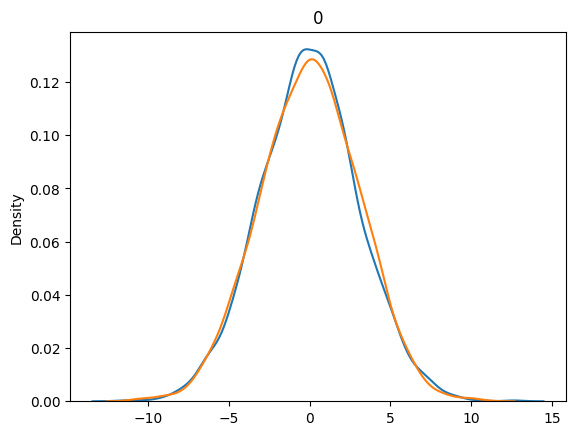

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


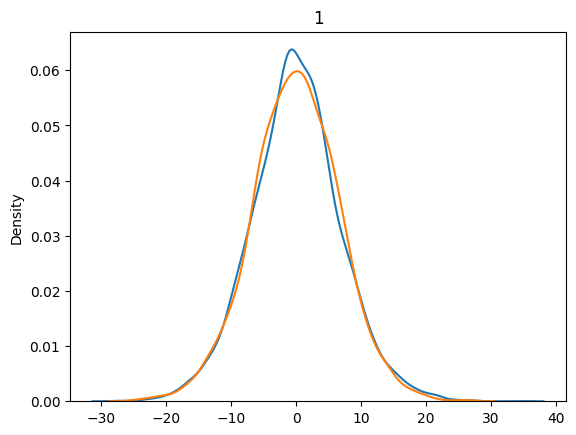

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


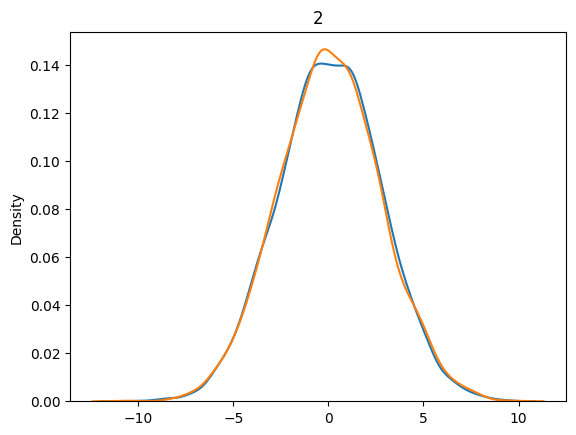

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


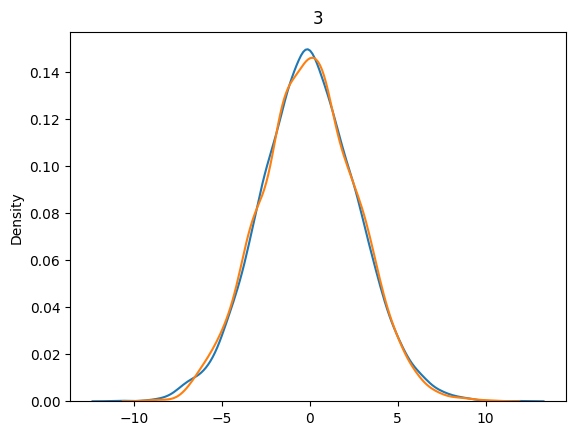

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


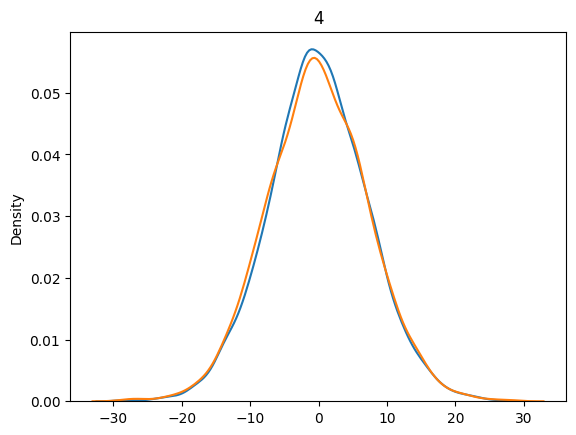

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


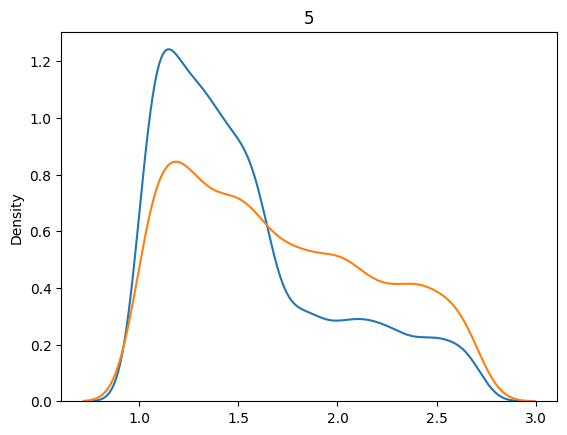

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


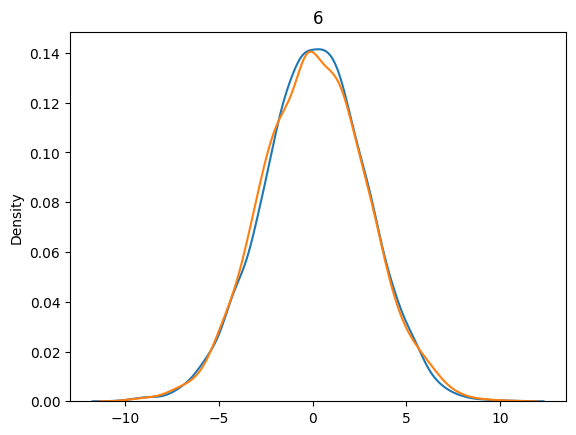

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


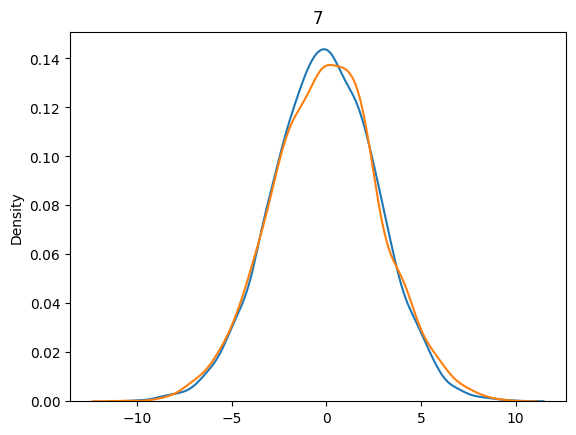

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


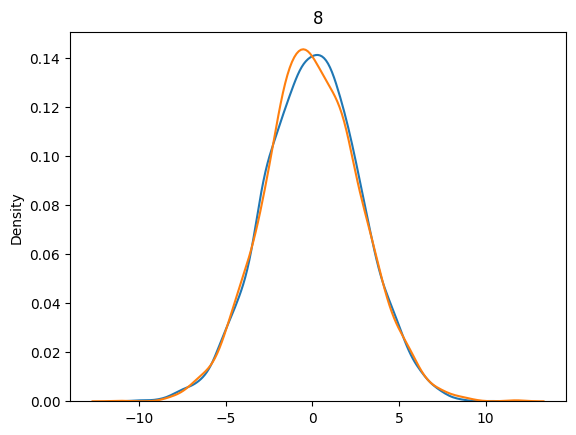

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


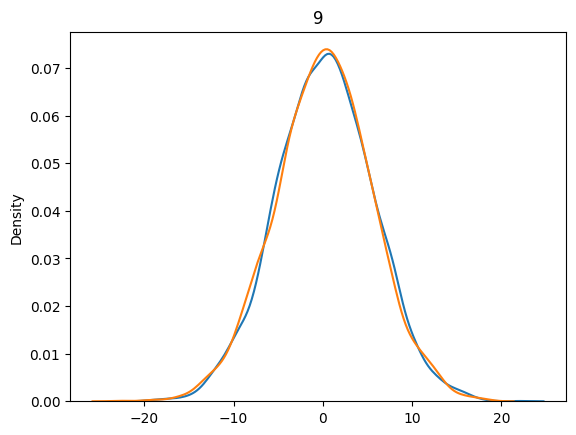

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


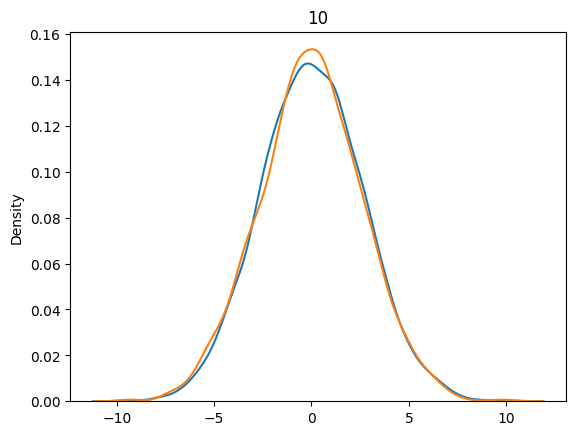

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


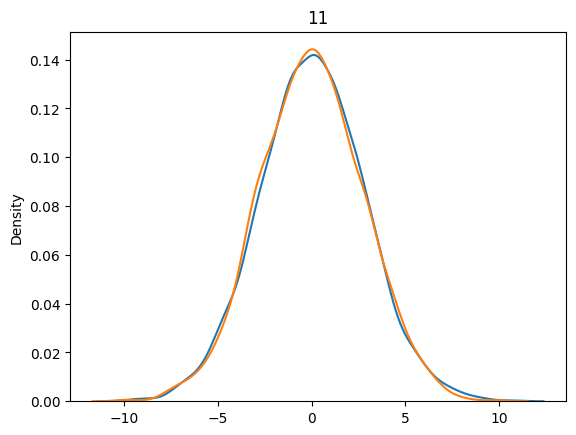

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


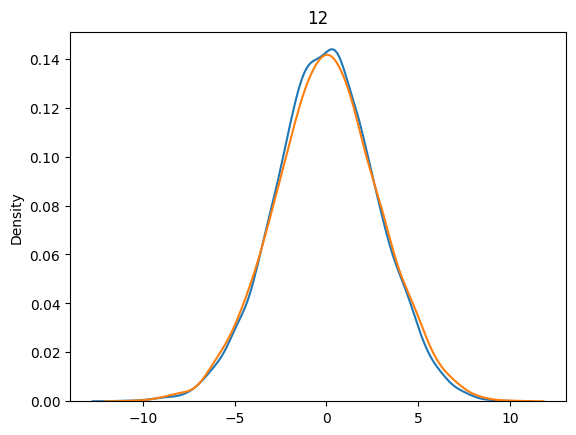

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


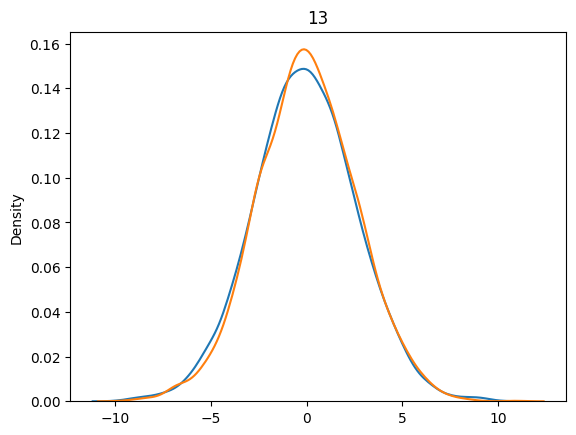

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


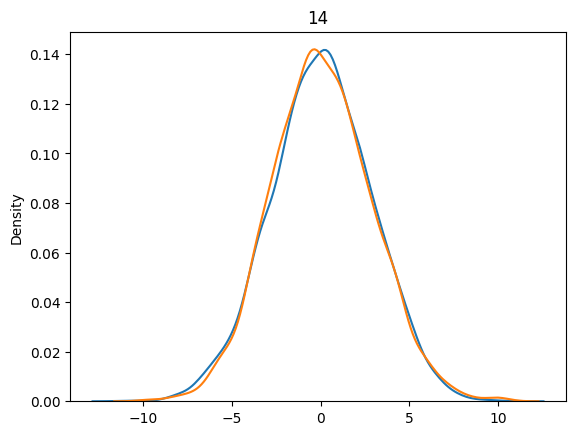

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


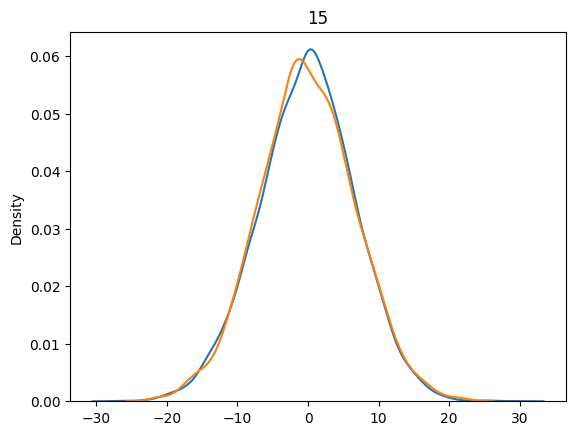

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


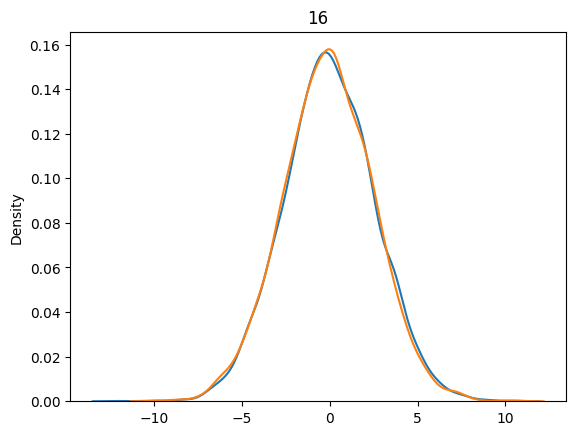

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


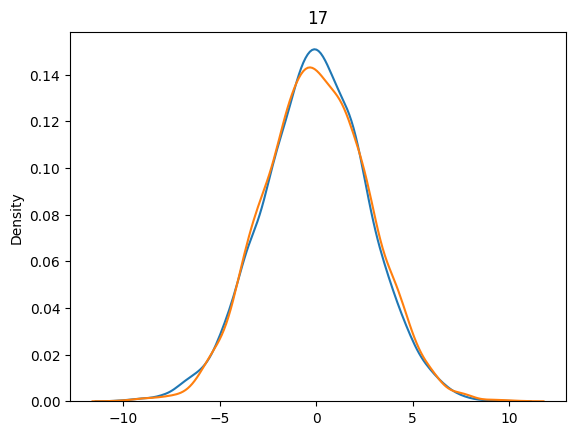

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


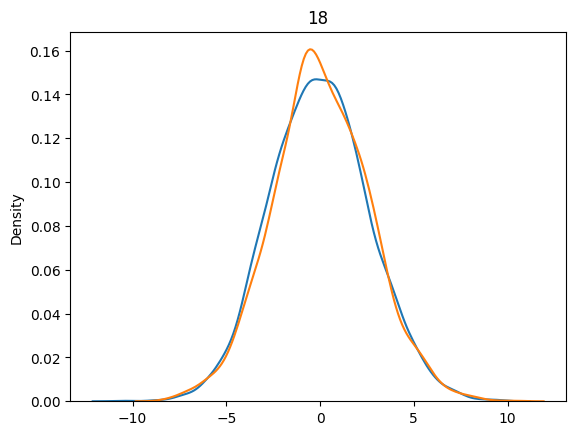

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


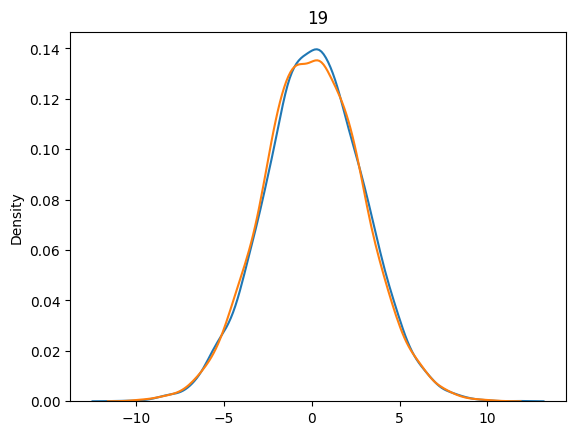

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


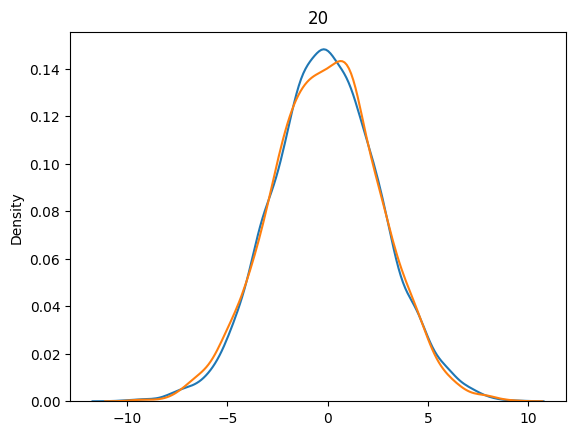

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


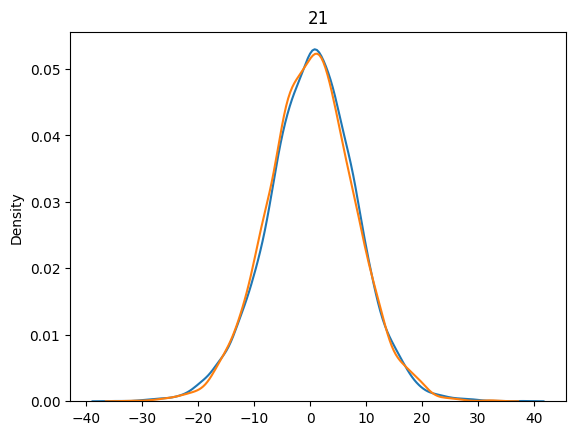

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


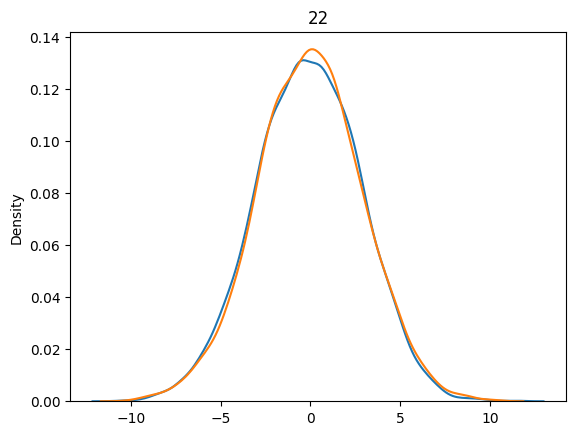

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


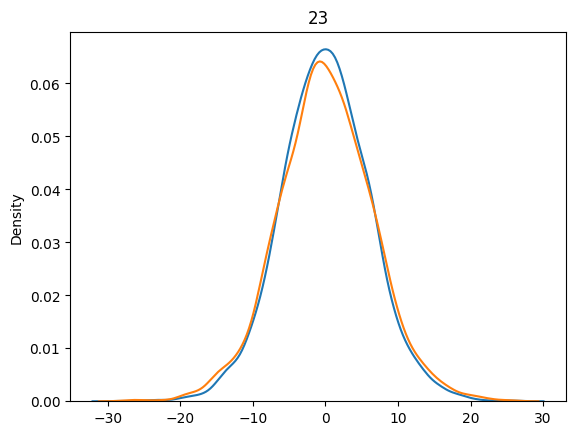

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


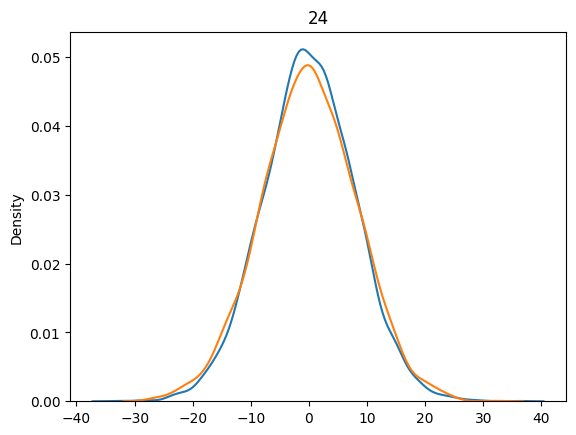

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


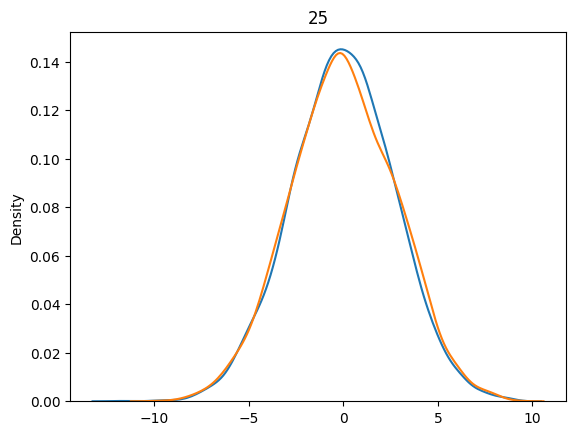

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


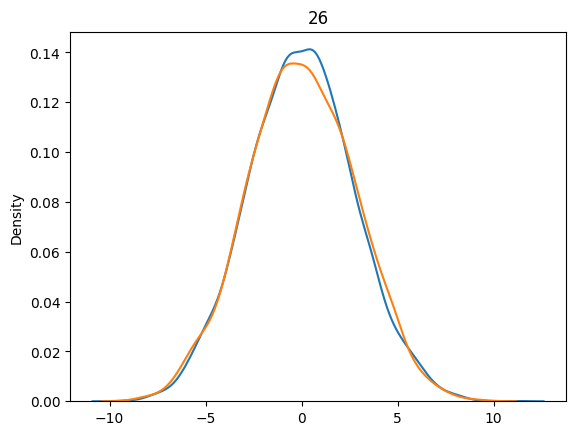

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


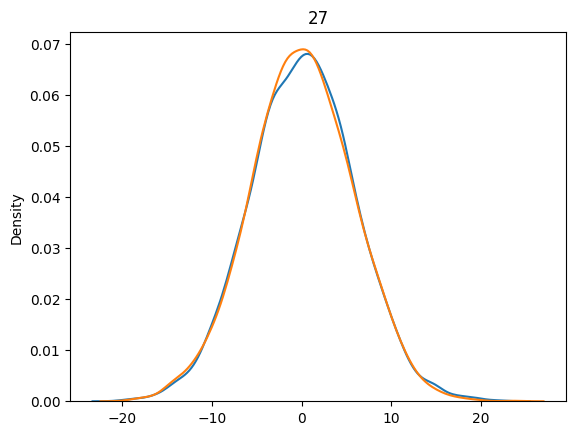

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


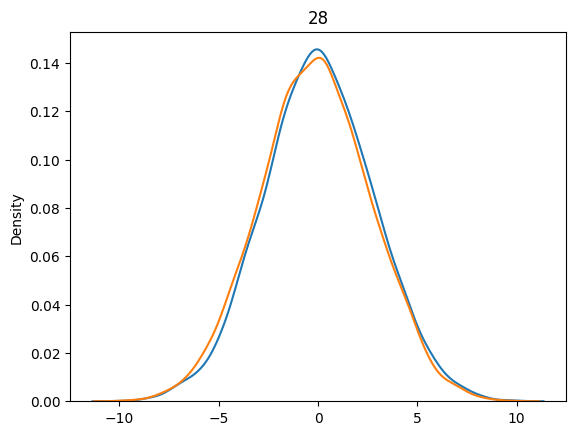

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


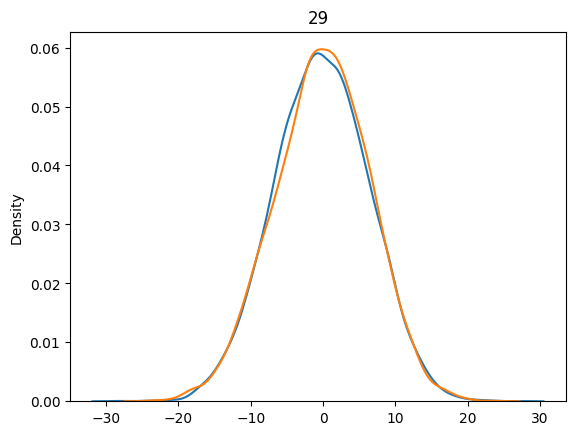

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


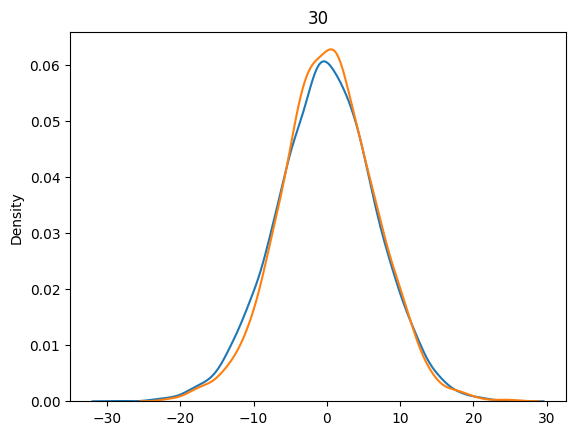

In [23]:
import seaborn as sns

for col_i in test_data.columns:
    sns.distplot(train_data[[col_i]], hist=False)
    sns.distplot(test_data[[col_i]], hist=False)
    plt.title(col_i)
    plt.show()

# Исследуем подходы и модели

## Ставим задачу машинного обучения используем все

In [26]:
# https://lightautoml.readthedocs.io/en/latest/python_api/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'logloss')

Не похоже чтобы колонки были категориальными оставляем просто как есть и пусть LAMA сама разберется =)
Исключать какие либо колонки из рассмотрения тоже пока не будем.

In [30]:
roles = {'target': 'target',
         'drop': '5'}

In [31]:
automl = TabularAutoML(task = task, 
                    timeout = 3600 * 3, # 3600 секунд = 1 час
                    general_params = {'use_algos': [['cb', 'lgb', 'linear_l2']]},
                    cb_params = {'default_params': {'task_type': 'GPU'}},
                    reader_params = {'n_jobs': 12},
                    timing_params ={'mode': 0}
                    )

In [32]:
# запускаем обучение на данных и подбор оптимальных параметров
# из ансамбля моделей
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose=4)

[17:14:01] Stdout logging level is DEBUG.
[17:14:01] Task: binary

[17:14:01] Start automl preset with listed constraints:
[17:14:01] - time: 10800.00 seconds
[17:14:01] - CPU: 4 cores
[17:14:01] - memory: 16 GB

[17:14:01] Train data shape: (5570, 32)

[17:14:02] Feats was rejected during automatic roles guess: []
[17:14:02] Layer 1 train process start. Time left 10799.25 secs
[17:14:02] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:14:02] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [30, 31, 32, 33, 34, 35, 36, 37], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11], dtype=int32), 'data_size': 38}
[17:14:02] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:14:02] Linear model: C = 1e-05 score = -0.5993752735039918
[17:14:02] Linear model: C = 5e-05 score = -0.5984354262345569
[17

Тут некоторая тонкость использования метдов **automl.fit_predict()** и **automl.predict()**.

Когда automl обучает модели методом **fit_predict()** это происходит с помощью кросс валидации (в нашем случае на 5 подвыборках из обучающей выборки). 

В процессе этого **automl** будет собирать статистику по фолдам, которые в данный момент являются валидационными и записывать ее.

Поэтому и предсказанные значения по валидационным фолдам и полученные по ней метрики будут получены из метода automl.fit_predict(обучающая_выборка).

automl.predict(данные) использует уже готовый полученный ансамбль моделей МЛ, некакого разбиения на подвыборки тут нет. Его праивльно использовать на тестовой выборке, - тех данных которые не участвовали при обучени модели.

Предсказывать на automl.predict(обучающая_выборка) не правильно, таким образом мы померим метрику на тех данных на которых учили модель. А правильно делать это только на валлидационых фолдах при кросс валидации.

### Сохраним полученный ансамбль моделей в файл

In [33]:
model_path = 'model/lightautoml_model_2.pkl'
oof_pred_path = 'model/lightautoml_model_oof_pred_2.pkl'


In [34]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path)


['model/lightautoml_model_oof_pred_2.pkl']

### Загрузим сохраненную ранее модель

In [55]:
porog = 0.3

In [56]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [57]:
# проверка полученного ансамбля на валидационной выборке
valid_pred = automl.predict(valid_data)

In [58]:
valid_pred = (valid_pred.data[:, 0] > porog).astype(int)

In [59]:
valid_pred

array([1, 1, 0, ..., 0, 0, 0])

In [60]:
np.unique(valid_pred, return_counts=True)
# porog = 0.5
# (array([0, 1]), array([993, 400])) 0.5

(array([0, 1]), array([1010,  383]))

In [61]:
valid_data['target'].values

array([0, 1, 0, ..., 0, 0, 0])

In [62]:
np.unique(valid_data['target'].values, return_counts=True)

(array([0, 1]), array([993, 400]))

In [63]:
# оценка полученной метрики на валидационном наборе данных
print(f"OOF f1_score: {sk_metrics.f1_score(tr_data['target'].values, (oof_pred.data[:, 0] > porog).astype(int))}")
print(f"VAL f1_score: {sk_metrics.f1_score(valid_data['target'].values, valid_pred)}")

# porog = 0.5
# OOF f1_score: 0.9978077043532728
# VAL f1_score: 1.0

OOF f1_score: 0.8635930047694754
VAL f1_score: 0.8786717752234994


In [64]:
OOF_f1_score = []
VAL_f1_score = []
porogs = np.arange(0, 1, 0.1)

for porog_i in porogs:
    # проверка полученного ансамбля на валидационной выборке
    valid_pred = automl.predict(valid_data)
    valid_pred = (valid_pred.data[:, 0] > porog_i).astype(int)

    # оценка полученной метрики на валидационном наборе данных
    OOF_f1_score.append(sk_metrics.f1_score(tr_data['target'].values, (oof_pred.data[:, 0] > porog_i).astype(int)))
    VAL_f1_score.append(sk_metrics.f1_score(valid_data['target'].values, valid_pred))

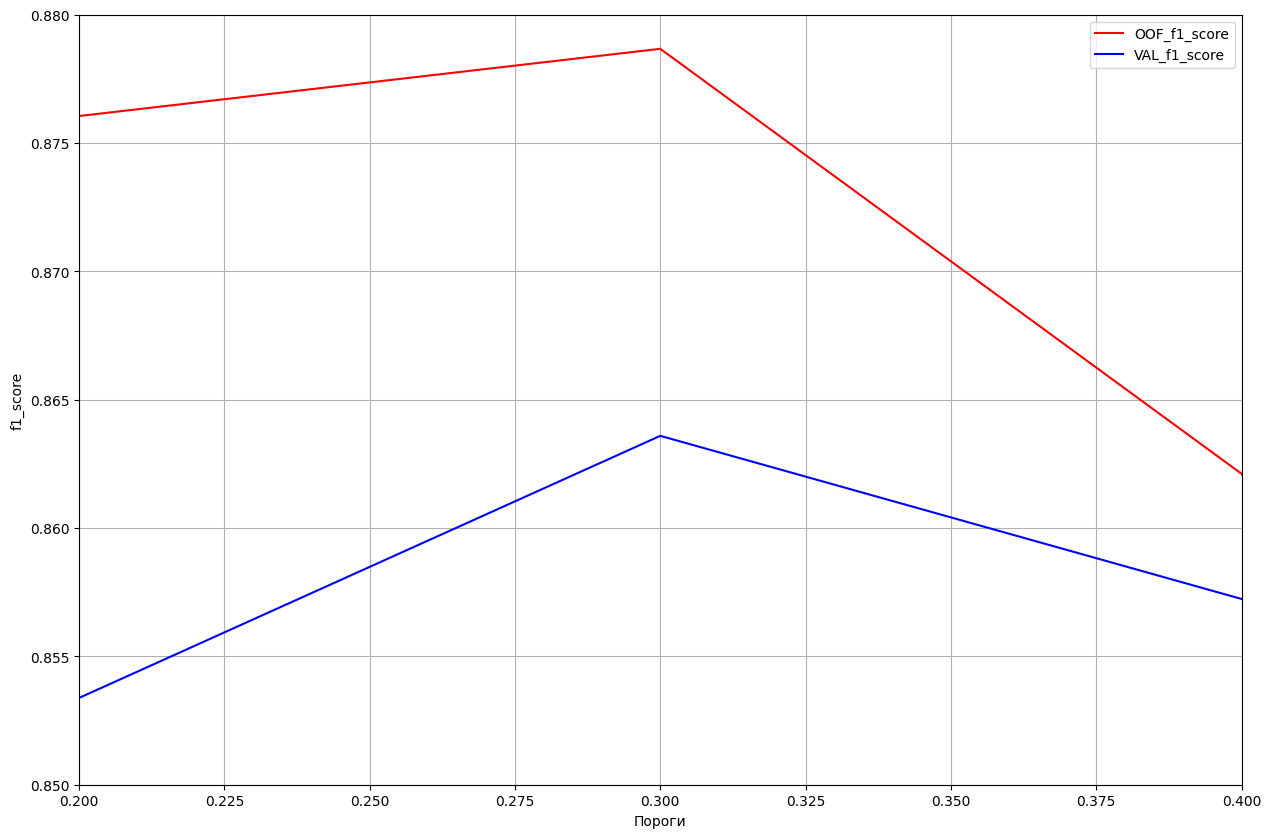

In [99]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(porogs, VAL_f1_score, '-r', label='OOF_f1_score')
plt.plot(porogs, OOF_f1_score, '-b', label='VAL_f1_score')
plt.xlabel('Пороги')
plt.ylabel('f1_score')
plt.xlim(0.2, 0.4)
plt.ylim(0.85, 0.88)
plt.grid()
plt.legend()
plt.show()


## Обучение модели на всей обучающей выборке и предсказание на тестовых данных (CatBoost) используем все

In [84]:
task = Task('binary', loss= 'logloss', metric = 'logloss')

In [85]:
roles = {'target': 'target',
         'drop': '5'}

In [86]:
automl = TabularAutoML(task = task, 
                    timeout = 3600 * 3, # 3600 секунд = 1 час
                    general_params = {'use_algos': [['cb', 'lgb', 'linear_l2']]},
                    cb_params = {'default_params': {'task_type': 'GPU'}},
                    reader_params = {'n_jobs': 12},
                    timing_params ={'mode': 0}
                    )

In [87]:
# обучение этим подходом на всех имеющиеся обучающих данных
oof_pred = automl.fit_predict(train_data, roles = roles, verbose=4)

[17:24:30] Stdout logging level is DEBUG.
[17:24:30] Task: binary

[17:24:30] Start automl preset with listed constraints:
[17:24:30] - time: 10800.00 seconds
[17:24:30] - CPU: 4 cores
[17:24:30] - memory: 16 GB

[17:24:30] Train data shape: (6963, 32)

[17:24:30] Feats was rejected during automatic roles guess: []
[17:24:30] Layer 1 train process start. Time left 10799.84 secs
[17:24:30] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:24:30] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [30, 31, 32, 33, 34, 35, 36, 37], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11], dtype=int32), 'data_size': 38}
[17:24:30] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:24:30] Linear model: C = 1e-05 score = -0.5992642708031805
[17:24:30] Linear model: C = 5e-05 score = -0.5982254964151745
[17

### Сохраним полученный ансамбль моделей в файл

In [88]:
model_path = 'model/lightautoml_model_final_2.pkl'
oof_pred_path = 'model/lightautoml_model_oof_pred_final_2.pkl'

In [89]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path) 

['model/lightautoml_model_oof_pred_final_2.pkl']

### Загрузим сохраненую ранее модель из файла

In [90]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [91]:
# оценка полученной метрики на всем наборе данных
print(f"FULL f1_score: {sk_metrics.f1_score(train_data['target'].values, (oof_pred.data[:, 0] > porog).astype(int))}")

FULL f1_score: 0.8745323023197804


### Предскажем на тестовой выборке

In [92]:
# предсказание ансамблем моделей на тестовых данных
test_pred = automl.predict(test_data)

### Сделаем файл sabmita

In [93]:
submission_path = 'submission/lightautoml_model_final_submission_3_porog_03.csv'

In [94]:
submission['target'] = (test_pred.data[:, 0] > porog).astype(int)

In [95]:
submission.head()

,target
0,0
1,0
2,0
3,1
4,0


In [96]:
submission.to_csv(submission_path, index = False)

In [97]:
# совпадают ли количество рядов у таблицы нашего предсказания
# и "sample_submission.csv"
len(submission)==len(submission)

True

**Краткие выводы:**
* смена задачи на task = Task('binary', loss= 'logloss', metric = 'logloss') сразу дала масимально положительный эффект на LGB
кажется объяснение этому есть тут!
https://dyakonov.org/2021/05/27/imbalance/

* подбор оптимального порога интересная вещь, в этом соревновании разницы нет никакой. Дело в чем то еще ! =)
